In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('Google_Stock_Price_Train.csv')
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [4]:
df.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


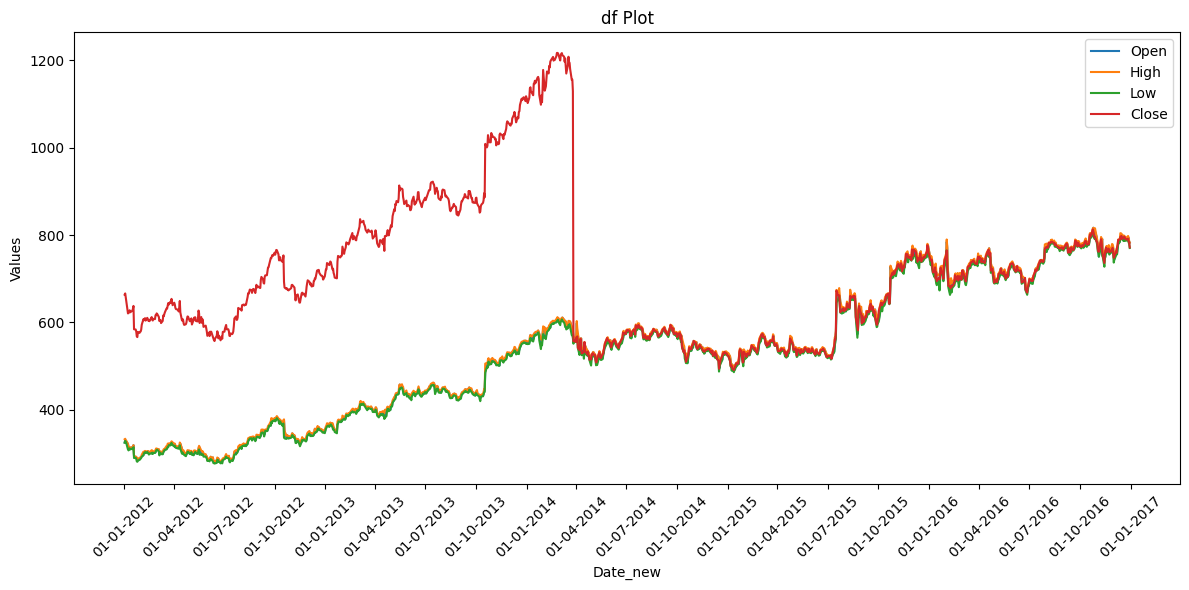

In [5]:
# Convert the first column to datetime
df['Date_new'] = pd.to_datetime(df['Date'])

# Convert 'close' and 'Volume' columns to float from object
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)

# Set the Date_new as the index
df.set_index('Date_new', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))

# Plot all the columns of interest
for column in 'Open', 'High', 'Low', 'Close':
    plt.plot(df.index, df[column], label=column)

# Formatting the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # One tick every 3 months as there are too many dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Format the date in (dd-mm-yy) format
plt.xticks(rotation=45)  # Rotate dates to accommodate without overlapping

# Add labels and title
plt.xlabel('Date_new')
plt.ylabel('Values')
plt.title('df Plot')
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-ticks

# Show the plot
plt.show()

In [6]:
# deep copy of the dataframe
df_new = df.copy()
# use lambda function to create a new column 'Close' which is close/2 if the current close price is greater than the high value, else close
df_new['Close'] = df_new.apply(lambda x: x['Close']/2 if x['Close'] > x['High'] else x['Close'], axis=1)
df_new.head()

,Date,Open,High,Low,Close,Volume
Date_new,,,,,,
2012-01-03,1/3/2012,325.25,332.83,324.97,331.795,7380500.0
2012-01-04,1/4/2012,331.27,333.87,329.08,333.225,5749400.0
2012-01-05,1/5/2012,329.83,330.75,326.89,328.605,6590300.0
2012-01-06,1/6/2012,328.34,328.77,323.68,324.120,5405900.0
2012-01-09,1/9/2012,322.04,322.29,309.46,310.380,11688800.0


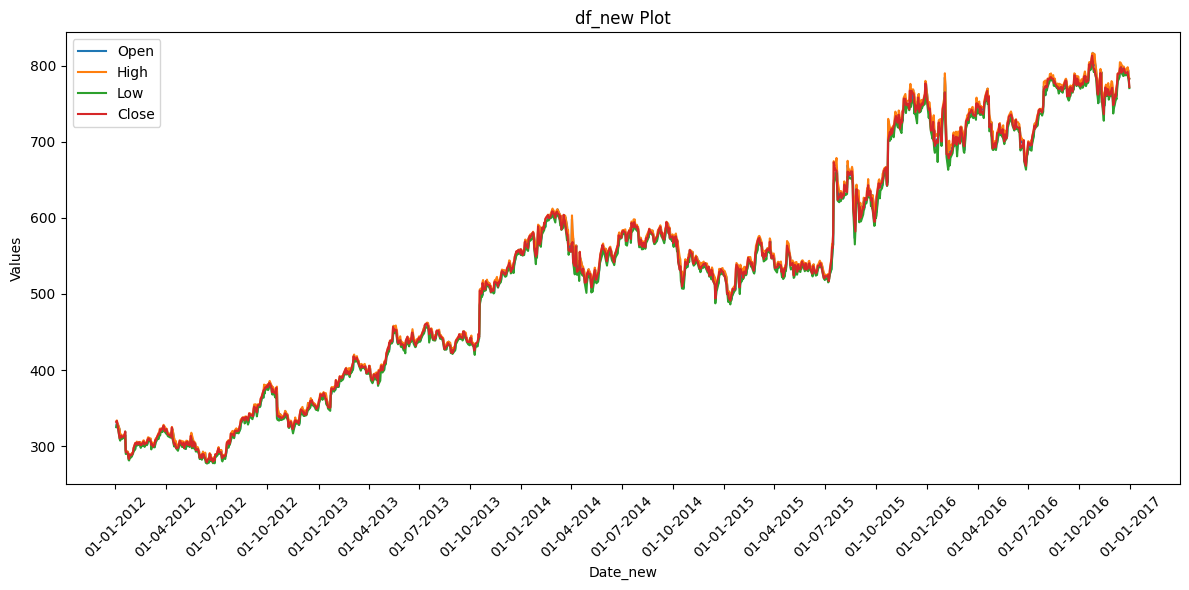

In [7]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot all the columns of interest
for column in 'Open', 'High', 'Low', 'Close':
    plt.plot(df_new.index, df_new[column], label=column)

# Formatting the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # One tick every 3 months as there are too many dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))  # Format the date in (dd-mm-yy) format
plt.xticks(rotation=45)  # Rotate dates to accommodate without overlapping

# Add labels and title
plt.xlabel('Date_new')
plt.ylabel('Values')
plt.title('df_new Plot')
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-ticks

# Show the plot
plt.show()

# Data Preperation

In [8]:
# Extract the date column
dates = df_new['Date'].values

# Select columns of interest for prediction
features = df_new[['Close']].values  # Selected columns
targets = df_new[['Close']].values  # Target columns

# Set the time step
time_step = 10

# Create sequences
def create_df_newset(features, targets, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step)])
        y.append(targets[i + time_step])
    return np.array(X), np.array(y)

# Split the df_newset into training and validation sets (80:20 ratio)
train_size = int(len(features) * 0.8)
features_train, features_val = features[:train_size], features[train_size:]
targets_train, targets_val = targets[:train_size], targets[train_size:]

# Scale the features and targets
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on the training df_new only
scaled_features_train = scaler.fit_transform(features_train)
scaled_targets_train = scaler.fit_transform(targets_train)

# Transform validation df_new using the fitted scalers
scaled_features_val = scaler.transform(features_val)
scaled_targets_val = scaler.transform(targets_val)

# Create sequences for training and validation sets
X_train, y_train = create_df_newset(scaled_features_train, scaled_targets_train, time_step)
X_val, y_val = create_df_newset(scaled_features_val, scaled_targets_val, time_step)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# RNN

In [9]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)  # RNN layer
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected layer

    def forward(self, x):
        out, _ = self.rnn(x)  # Forward pass through RNN
        out = out[:, -1, :]   # Get the last time step
        out = self.fc(out)    # Pass through fully connected layer
        return out

In [10]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 1
num_layers = 1
output_size = y_train.shape[1]  # Number of targets (Open, High, Low)
num_epochs = 100
batch_size = 1
learning_rate = 0.001

# Initialize the model
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)  # Move model to GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    rnn_model.train()
    optimizer.zero_grad()
    outputs = rnn_model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

    # Validation
    rnn_model.eval()
    val_outputs = rnn_model(X_val_tensor.to(device))
    val_loss = criterion(val_outputs, y_val_tensor.to(device))

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [1/100], Loss: 1.7719, Val Loss: 3.3273
Epoch [2/100], Loss: 1.7675, Val Loss: 3.3215
Epoch [3/100], Loss: 1.7631, Val Loss: 3.3157
Epoch [4/100], Loss: 1.7588, Val Loss: 3.3099
Epoch [5/100], Loss: 1.7544, Val Loss: 3.3042
Epoch [6/100], Loss: 1.7501, Val Loss: 3.2985
Epoch [7/100], Loss: 1.7458, Val Loss: 3.2929
Epoch [8/100], Loss: 1.7416, Val Loss: 3.2873
Epoch [9/100], Loss: 1.7373, Val Loss: 3.2818
Epoch [10/100], Loss: 1.7331, Val Loss: 3.2763
Epoch [11/100], Loss: 1.7290, Val Loss: 3.2709
Epoch [12/100], Loss: 1.7248, Val Loss: 3.2655
Epoch [13/100], Loss: 1.7207, Val Loss: 3.2602
Epoch [14/100], Loss: 1.7166, Val Loss: 3.2549
Epoch [15/100], Loss: 1.7126, Val Loss: 3.2497
Epoch [16/100], Loss: 1.7086, Val Loss: 3.2445
Epoch [17/100], Loss: 1.7046, Val Loss: 3.2394
Epoch [18/100], Loss: 1.7006, Val Loss: 3.2343
Epoch [19/100], Loss: 1.6967, Val Loss: 3.2293
Epoch [20/100], Loss: 1.6927, Val Loss: 3.2243
Epoch [21/100], Loss: 1.6889, Val Loss: 3.2194
Epoch [22/100], Loss: 

In [11]:
# Make predictions
rnn_model.eval()
with torch.no_grad():
    predicted_prices = rnn_model(X_val_tensor.to(device))
    
# Inverse transform the predicted values to original scale
predicted_prices_inv = scaler.inverse_transform(predicted_prices.cpu().numpy())
actual_prices_inv = scaler.inverse_transform(y_val_tensor.numpy())
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices_inv, predicted_prices_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Root Mean Squared Error (RMSE): 851.3144


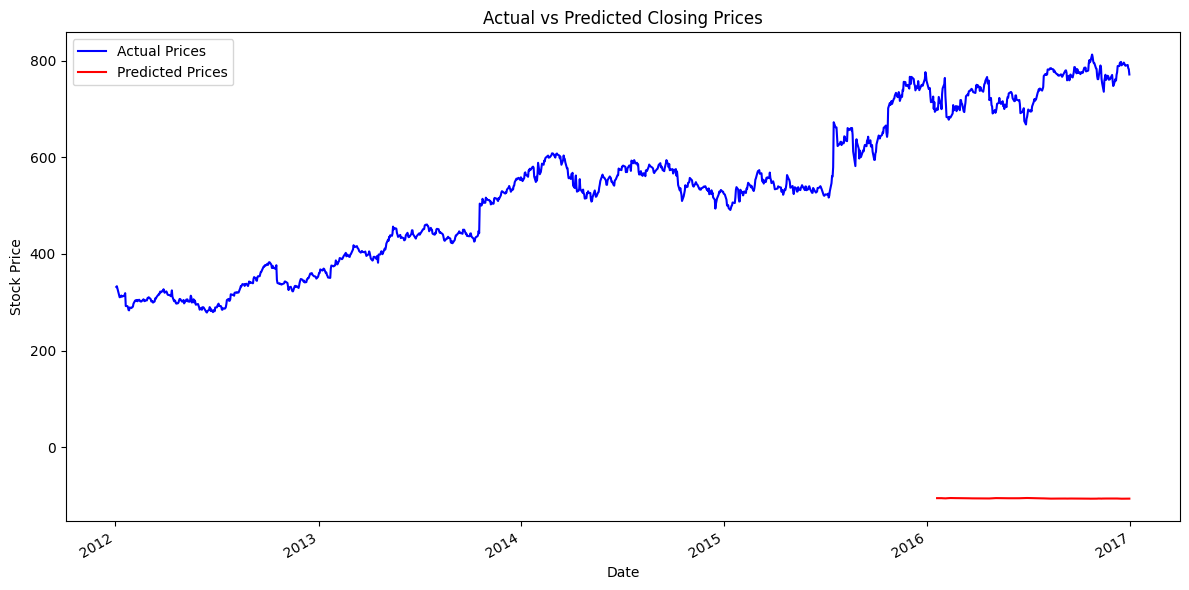

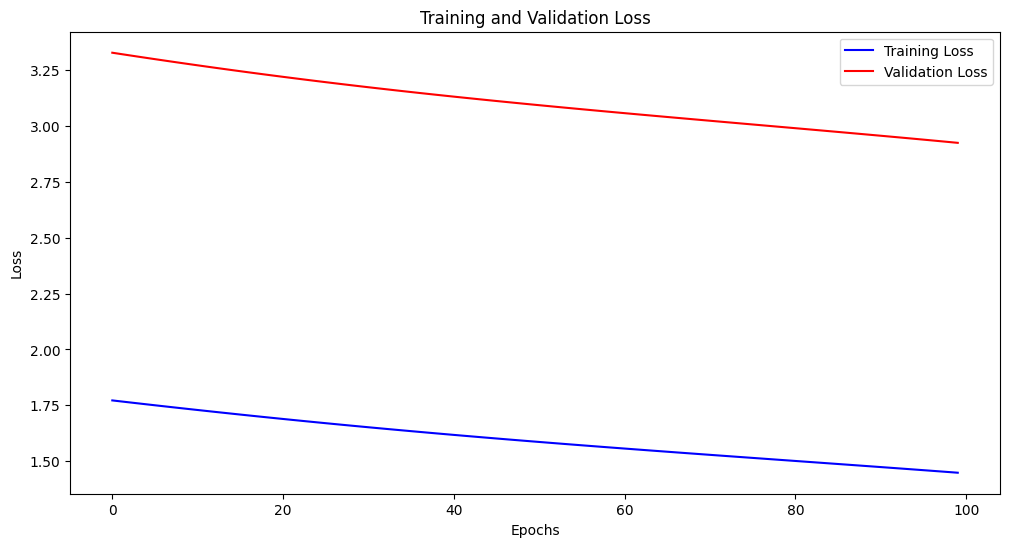

In [12]:
df_new['Date'] = pd.to_datetime(df_new['Date'])

# Full actual prices and dates
full_actual_prices = df_new[['Close']].values
full_dates = df_new['Date'].values

# Create a new figure for the actual vs predicted prices
plt.figure(figsize=(12, 6))

# Plot the entire actual prices
plt.plot(full_dates, full_actual_prices, label='Actual Prices', color='blue')

# Calculate the starting index for the validation set
val_start_index = train_size + time_step  # Adjust for the time step
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv, 
         label='Predicted Prices', 
         color='red')

# Formatting the plot
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Improve x-axis date formatting
plt.gcf().autofmt_xdate()  # Auto format date labels
plt.legend()
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch [1/100], Loss: 0.0671, Val Loss: 0.2640
Epoch [2/100], Loss: 0.0583, Val Loss: 0.2043
Epoch [3/100], Loss: 0.0560, Val Loss: 0.1857
Epoch [4/100], Loss: 0.0509, Val Loss: 0.1855
Epoch [5/100], Loss: 0.0439, Val Loss: 0.1913
Epoch [6/100], Loss: 0.0381, Val Loss: 0.1867
Epoch [7/100], Loss: 0.0339, Val Loss: 0.1552
Epoch [8/100], Loss: 0.0277, Val Loss: 0.1038
Epoch [9/100], Loss: 0.0192, Val Loss: 0.0507
Epoch [10/100], Loss: 0.0123, Val Loss: 0.0181
Epoch [11/100], Loss: 0.0081, Val Loss: 0.0057
Epoch [12/100], Loss: 0.0025, Val Loss: 0.0016
Epoch [13/100], Loss: 0.0018, Val Loss: 0.0014
Epoch [14/100], Loss: 0.0079, Val Loss: 0.0074
Epoch [15/100], Loss: 0.0084, Val Loss: 0.0108
Epoch [16/100], Loss: 0.0083, Val Loss: 0.0054
Epoch [17/100], Loss: 0.0047, Val Loss: 0.0009
Epoch [18/100], Loss: 0.0016, Val Loss: 0.0030
Epoch [19/100], Loss: 0.0011, Val Loss: 0.0073
Epoch [20/100], Loss: 0.0012, Val Loss: 0.0099
Epoch [21/100], Loss: 0.0014, Val Loss: 0.0106
Epoch [22/100], Loss: 

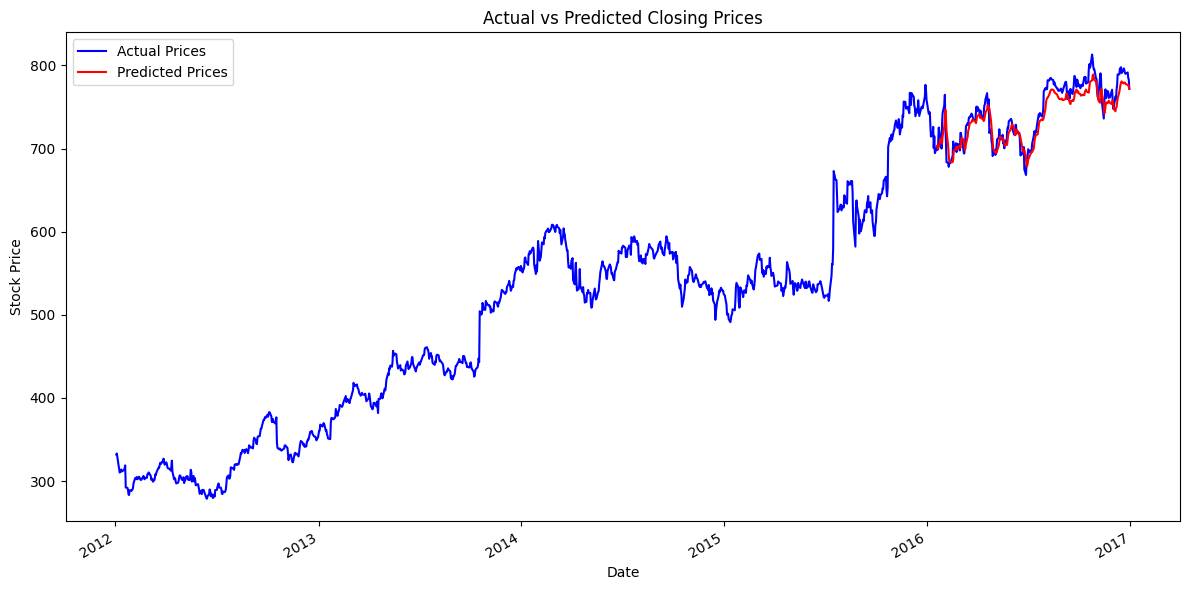

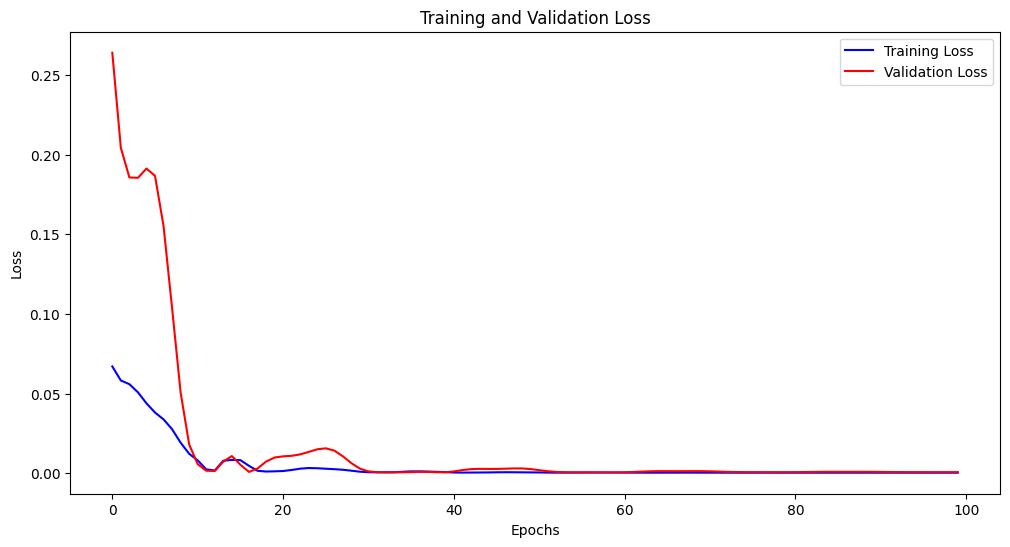

In [13]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 10
num_layers = 1
output_size = y_train.shape[1]  # Number of targets (Open, High, Low)
num_epochs = 100
batch_size = 1
learning_rate = 0.01

# Initialize the model
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)  # Move model to GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    rnn_model.train()
    optimizer.zero_grad()
    outputs = rnn_model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

    # Validation
    rnn_model.eval()
    val_outputs = rnn_model(X_val_tensor.to(device))
    val_loss = criterion(val_outputs, y_val_tensor.to(device))

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Make predictions
rnn_model.eval()
with torch.no_grad():
    predicted_prices = rnn_model(X_val_tensor.to(device))
    
# Inverse transform the predicted values to original scale
predicted_prices_inv = scaler.inverse_transform(predicted_prices.cpu().numpy())
actual_prices_inv = scaler.inverse_transform(y_val_tensor.numpy())
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices_inv, predicted_prices_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

df_new['Date'] = pd.to_datetime(df_new['Date'])

# Full actual prices and dates
full_actual_prices = df_new[['Close']].values
full_dates = df_new['Date'].values

# Create a new figure for the actual vs predicted prices
plt.figure(figsize=(12, 6))

# Plot the entire actual prices
plt.plot(full_dates, full_actual_prices, label='Actual Prices', color='blue')

# Calculate the starting index for the validation set
val_start_index = train_size + time_step  # Adjust for the time step
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv, 
         label='Predicted Prices', 
         color='red')

# Formatting the plot
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Improve x-axis date formatting
plt.gcf().autofmt_xdate()  # Auto format date labels
plt.legend()
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch [1/100], Loss: 0.2677, Val Loss: 0.2641
Epoch [2/100], Loss: 0.0494, Val Loss: 0.0485
Epoch [3/100], Loss: 0.0882, Val Loss: 0.1611
Epoch [4/100], Loss: 0.0396, Val Loss: 0.2852
Epoch [5/100], Loss: 0.0492, Val Loss: 0.3174
Epoch [6/100], Loss: 0.0566, Val Loss: 0.2691
Epoch [7/100], Loss: 0.0468, Val Loss: 0.1895
Epoch [8/100], Loss: 0.0336, Val Loss: 0.1143
Epoch [9/100], Loss: 0.0284, Val Loss: 0.0639
Epoch [10/100], Loss: 0.0314, Val Loss: 0.0470
Epoch [11/100], Loss: 0.0308, Val Loss: 0.0589
Epoch [12/100], Loss: 0.0218, Val Loss: 0.0932
Epoch [13/100], Loss: 0.0170, Val Loss: 0.0997
Epoch [14/100], Loss: 0.0168, Val Loss: 0.0347
Epoch [15/100], Loss: 0.0081, Val Loss: 0.0039
Epoch [16/100], Loss: 0.0097, Val Loss: 0.0041
Epoch [17/100], Loss: 0.0009, Val Loss: 0.0074
Epoch [18/100], Loss: 0.0091, Val Loss: 0.0032
Epoch [19/100], Loss: 0.0060, Val Loss: 0.0131
Epoch [20/100], Loss: 0.0089, Val Loss: 0.0007
Epoch [21/100], Loss: 0.0015, Val Loss: 0.0100
Epoch [22/100], Loss: 

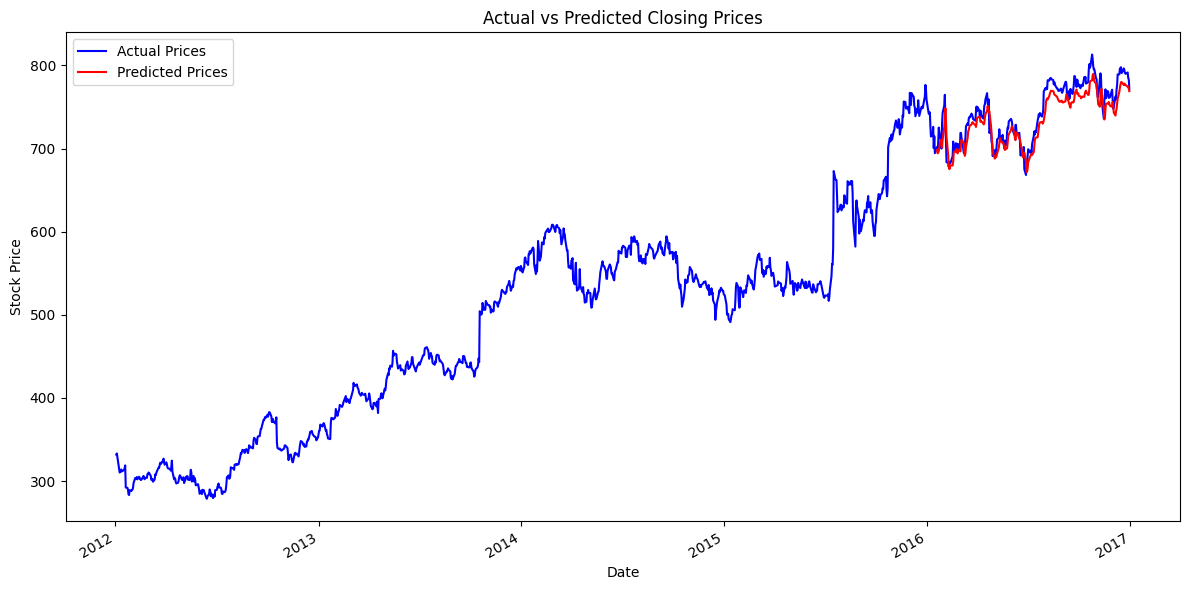

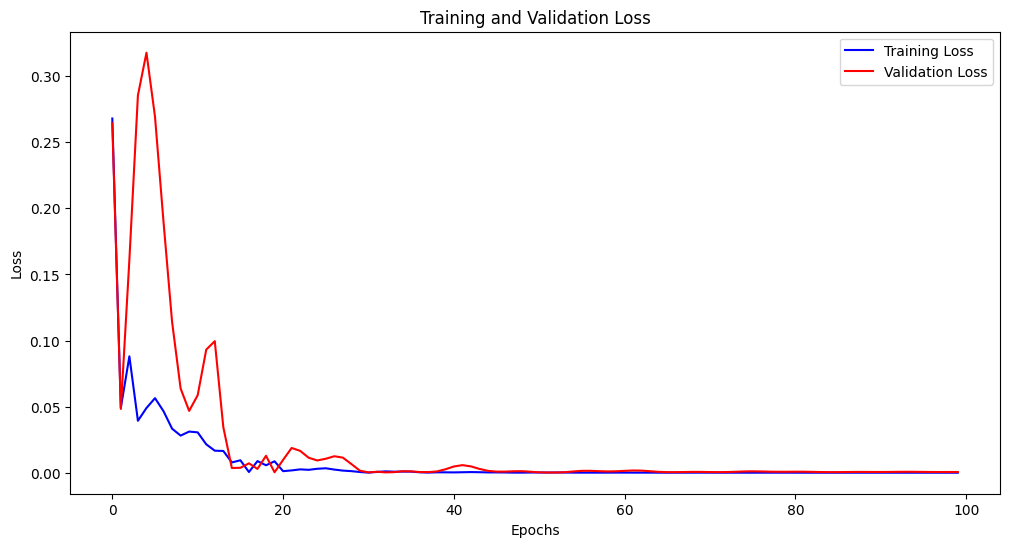

In [14]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 50
num_layers = 1
output_size = y_train.shape[1]  # Number of targets (Open, High, Low)
num_epochs = 100
batch_size = 7
learning_rate = 0.01

# Initialize the model
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)  # Move model to GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    rnn_model.train()
    optimizer.zero_grad()
    outputs = rnn_model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

    # Validation
    rnn_model.eval()
    val_outputs = rnn_model(X_val_tensor.to(device))
    val_loss = criterion(val_outputs, y_val_tensor.to(device))

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Make predictions
rnn_model.eval()
with torch.no_grad():
    predicted_prices = rnn_model(X_val_tensor.to(device))
    
# Inverse transform the predicted values to original scale
predicted_prices_inv = scaler.inverse_transform(predicted_prices.cpu().numpy())
actual_prices_inv = scaler.inverse_transform(y_val_tensor.numpy())
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices_inv, predicted_prices_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

df_new['Date'] = pd.to_datetime(df_new['Date'])

# Full actual prices and dates
full_actual_prices = df_new[['Close']].values
full_dates = df_new['Date'].values

# Create a new figure for the actual vs predicted prices
plt.figure(figsize=(12, 6))

# Plot the entire actual prices
plt.plot(full_dates, full_actual_prices, label='Actual Prices', color='blue')

# Calculate the starting index for the validation set
val_start_index = train_size + time_step  # Adjust for the time step
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv, 
         label='Predicted Prices', 
         color='red')

# Formatting the plot
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Improve x-axis date formatting
plt.gcf().autofmt_xdate()  # Auto format date labels
plt.legend()
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch [1/1000], Loss: 0.2957, Val Loss: 0.2907
Epoch [2/1000], Loss: 0.0506, Val Loss: 0.0167
Epoch [3/1000], Loss: 0.1324, Val Loss: 0.1303
Epoch [4/1000], Loss: 0.0472, Val Loss: 0.2773
Epoch [5/1000], Loss: 0.0484, Val Loss: 0.3500
Epoch [6/1000], Loss: 0.0617, Val Loss: 0.3489
Epoch [7/1000], Loss: 0.0621, Val Loss: 0.3026
Epoch [8/1000], Loss: 0.0527, Val Loss: 0.2342
Epoch [9/1000], Loss: 0.0409, Val Loss: 0.1604
Epoch [10/1000], Loss: 0.0329, Val Loss: 0.0971
Epoch [11/1000], Loss: 0.0325, Val Loss: 0.0598
Epoch [12/1000], Loss: 0.0360, Val Loss: 0.0517
Epoch [13/1000], Loss: 0.0331, Val Loss: 0.0657
Epoch [14/1000], Loss: 0.0245, Val Loss: 0.0948
Epoch [15/1000], Loss: 0.0196, Val Loss: 0.1219
Epoch [16/1000], Loss: 0.0214, Val Loss: 0.1080
Epoch [17/1000], Loss: 0.0191, Val Loss: 0.0548
Epoch [18/1000], Loss: 0.0103, Val Loss: 0.0115
Epoch [19/1000], Loss: 0.0087, Val Loss: 0.0009
Epoch [20/1000], Loss: 0.0100, Val Loss: 0.0011
Epoch [21/1000], Loss: 0.0015, Val Loss: 0.0061
E

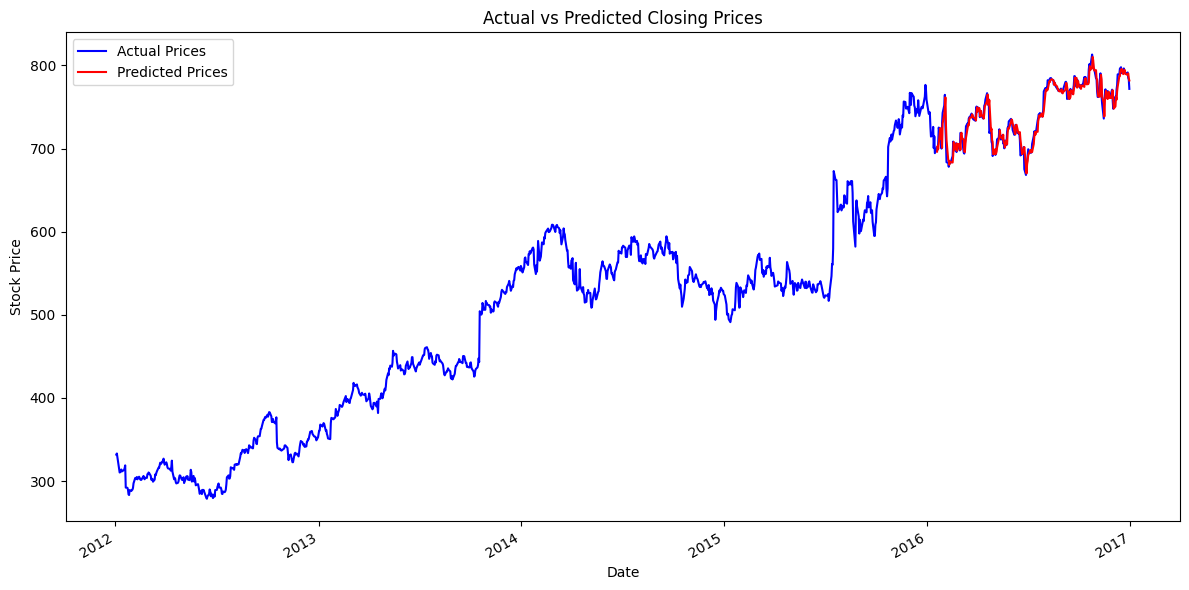

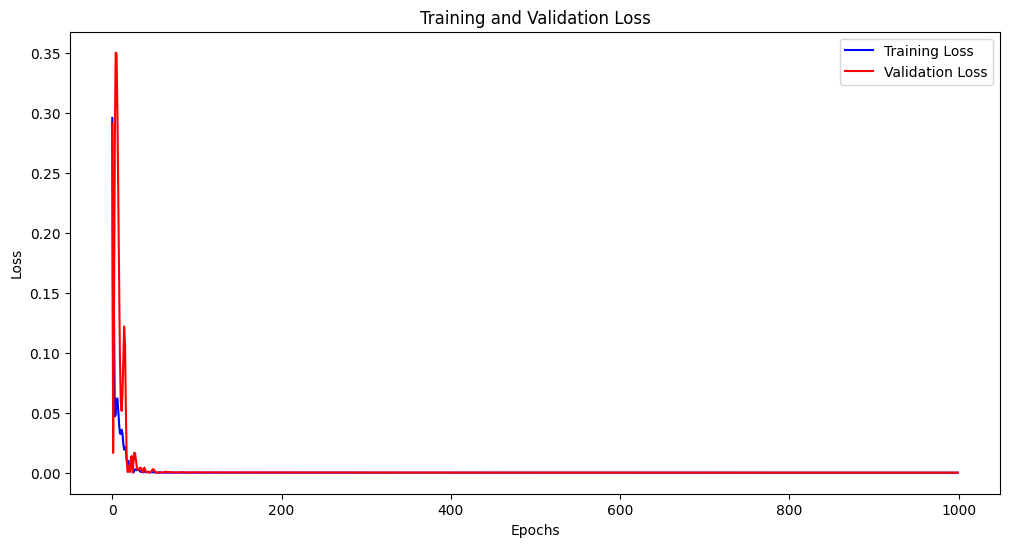

In [15]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 50
num_layers = 1
output_size = y_train.shape[1]  # Number of targets (Open, High, Low)
num_epochs = 1000
batch_size = 5
learning_rate = 0.01

# Initialize the model
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)  # Move model to GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    rnn_model.train()
    optimizer.zero_grad()
    outputs = rnn_model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

    # Validation
    rnn_model.eval()
    val_outputs = rnn_model(X_val_tensor.to(device))
    val_loss = criterion(val_outputs, y_val_tensor.to(device))

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Make predictions
rnn_model.eval()
with torch.no_grad():
    predicted_prices = rnn_model(X_val_tensor.to(device))
    
# Inverse transform the predicted values to original scale
predicted_prices_inv = scaler.inverse_transform(predicted_prices.cpu().numpy())
actual_prices_inv = scaler.inverse_transform(y_val_tensor.numpy())
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices_inv, predicted_prices_inv))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

df_new['Date'] = pd.to_datetime(df_new['Date'])

# Full actual prices and dates
full_actual_prices = df_new[['Close']].values
full_dates = df_new['Date'].values

# Create a new figure for the actual vs predicted prices
plt.figure(figsize=(12, 6))

# Plot the entire actual prices
plt.plot(full_dates, full_actual_prices, label='Actual Prices', color='blue')

# Calculate the starting index for the validation set
val_start_index = train_size + time_step  # Adjust for the time step
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv, 
         label='Predicted Prices', 
         color='red')

# Formatting the plot
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Improve x-axis date formatting
plt.gcf().autofmt_xdate()  # Auto format date labels
plt.legend()
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Testing Univariate RNN

Test RMSE for Close: 8.6691


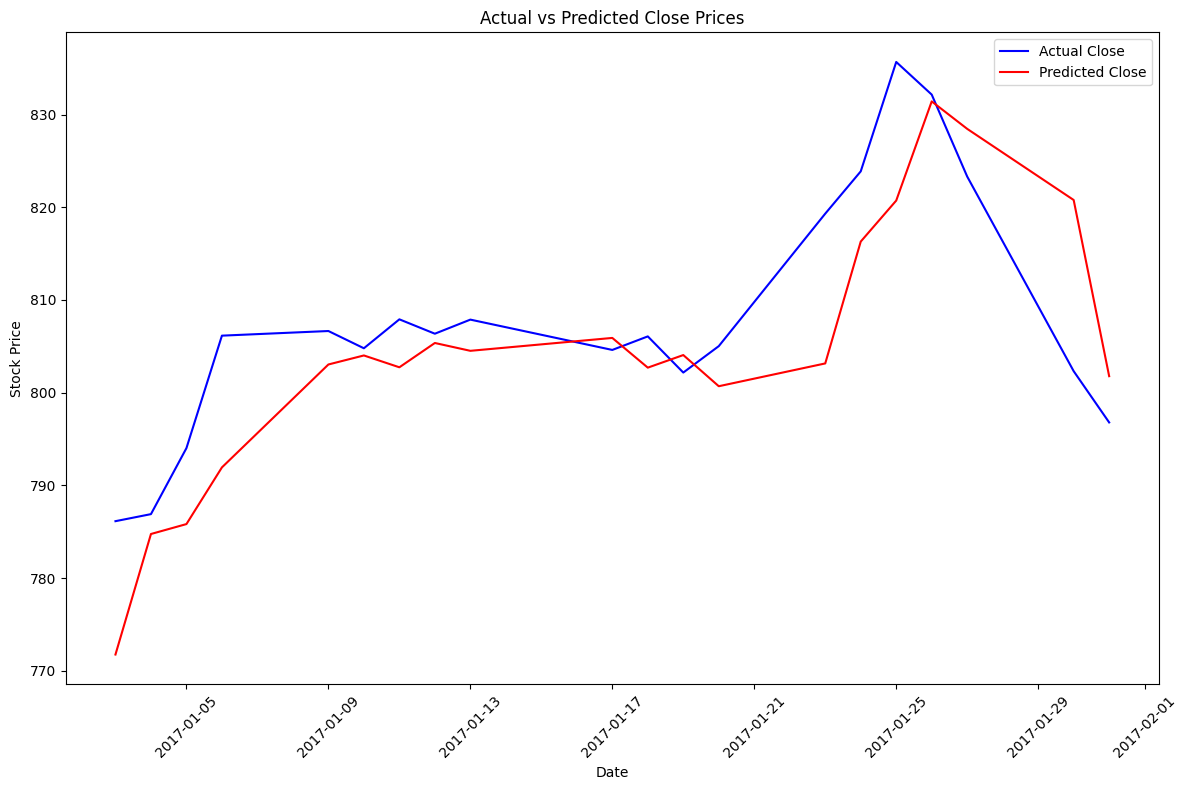

In [16]:
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
X_test = df_test[['Close']].values
# Scale the test features
X_test_scaled = scaler.transform(X_test)
last_val_entries = scaled_targets_val[-time_step:] # Last 'time_step' entries from the validation set
concat_test_data = np.concatenate((last_val_entries, X_test_scaled), axis=0)
X_test, y_test = create_df_newset(concat_test_data, concat_test_data, time_step)
# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Make predictions
rnn_model.eval()
with torch.no_grad():
    test_predicted = rnn_model(X_test_tensor.to(device))

# Inverse transform the predicted values to original scale
test_predicted_inv = scaler.inverse_transform(test_predicted.cpu().numpy())
actual_test_inv = scaler.inverse_transform(y_test_tensor.numpy())

# Calculate RMSE for each target
rmse = np.sqrt(mean_squared_error(actual_test_inv, test_predicted_inv))
print(f"Test RMSE for Close: {rmse:.4f}")

# Use the dates from the test dataset corresponding to the predictions
test_dates = df_test['Date'].values[-len(test_predicted_inv):]

# Plot actual vs predicted prices for 'Open', 'High', and 'Low'
plt.figure(figsize=(12, 8))

# Close
plt.plot(test_dates, actual_test_inv[:, 0], label='Actual Close', color='blue')
plt.plot(test_dates, test_predicted_inv[:, 0], label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# RNN Multi Variate (Multi output)

Epoch [1/1000], Loss: 0.3062, Val Loss: 0.5454
Epoch [2/1000], Loss: 0.1342, Val Loss: 0.1903
Epoch [3/1000], Loss: 0.0434, Val Loss: 0.0534
Epoch [4/1000], Loss: 0.0493, Val Loss: 0.1331
Epoch [5/1000], Loss: 0.0372, Val Loss: 0.1684
Epoch [6/1000], Loss: 0.0314, Val Loss: 0.1260
Epoch [7/1000], Loss: 0.0199, Val Loss: 0.0639
Epoch [8/1000], Loss: 0.0141, Val Loss: 0.0354
Epoch [9/1000], Loss: 0.0167, Val Loss: 0.0319
Epoch [10/1000], Loss: 0.0108, Val Loss: 0.0307
Epoch [11/1000], Loss: 0.0080, Val Loss: 0.0114
Epoch [12/1000], Loss: 0.0030, Val Loss: 0.0047
Epoch [13/1000], Loss: 0.0030, Val Loss: 0.0123
Epoch [14/1000], Loss: 0.0067, Val Loss: 0.0106
Epoch [15/1000], Loss: 0.0058, Val Loss: 0.0108
Epoch [16/1000], Loss: 0.0058, Val Loss: 0.0064
Epoch [17/1000], Loss: 0.0025, Val Loss: 0.0026
Epoch [18/1000], Loss: 0.0026, Val Loss: 0.0030
Epoch [19/1000], Loss: 0.0026, Val Loss: 0.0097
Epoch [20/1000], Loss: 0.0013, Val Loss: 0.0181
Epoch [21/1000], Loss: 0.0028, Val Loss: 0.0167
E

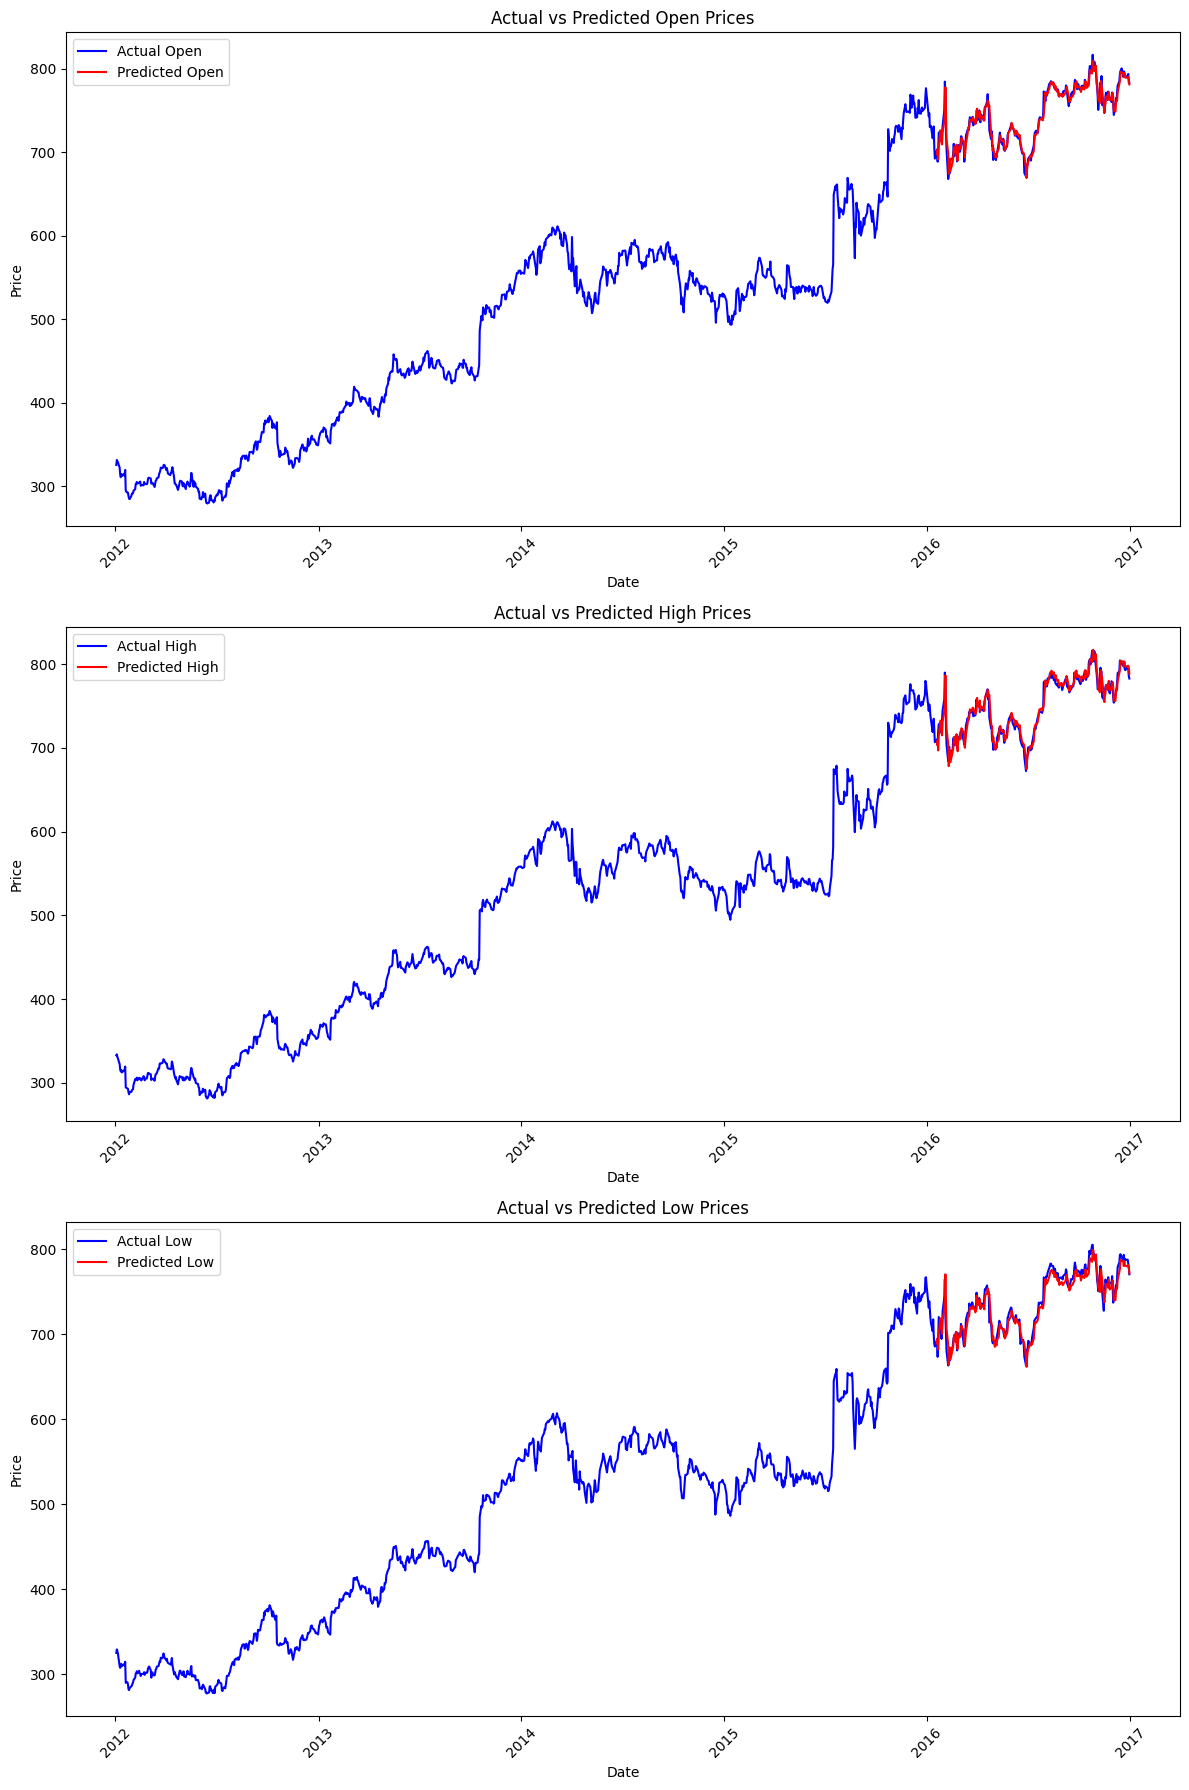

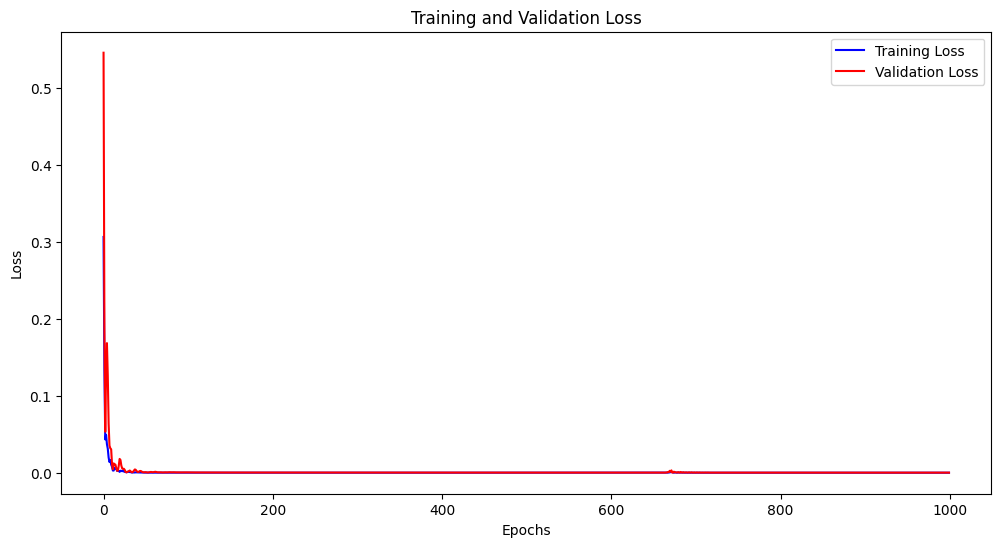

In [17]:
# Extract the date column
dates = pd.to_datetime(df_new['Date']).values

# Select columns of interest for prediction
features = df_new[['Open', 'High', 'Low']].values  # Selected columns
targets = df_new[['Open', 'High', 'Low']].values # Target columns

# Set the time step
time_step = 10

# Create sequences
def create_df_newset(features, targets, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step)])
        y.append(targets[i + time_step])
    return np.array(X), np.array(y)

# Split the df_newset into training and validation sets (80:20 ratio)
train_size = int(len(features) * 0.8)
features_train, features_val = features[:train_size], features[train_size:]
targets_train, targets_val = targets[:train_size], targets[train_size:]

# Scale the features and targets
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on the training df_new only
scaled_features_train = scaler.fit_transform(features_train)
scaled_targets_train = scaler.fit_transform(targets_train)

# Transform validation df_new using the fitted scalers
scaled_features_val = scaler.transform(features_val)
scaled_targets_val = scaler.transform(targets_val)

# Create sequences for training and validation sets
X_train, y_train = create_df_newset(scaled_features_train, scaled_targets_train, time_step)
X_val, y_val = create_df_newset(scaled_features_val, scaled_targets_val, time_step)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 50
num_layers = 1
output_size = y_train.shape[1]  # Number of targets (Open, High, Low)
num_epochs = 1000
batch_size = 5
learning_rate = 0.01

# Initialize the model
rnn_model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)  # Move model to GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    rnn_model.train()
    optimizer.zero_grad()
    outputs = rnn_model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

    # Validation
    rnn_model.eval()
    val_outputs = rnn_model(X_val_tensor.to(device))
    val_loss = criterion(val_outputs, y_val_tensor.to(device))

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Make predictions
rnn_model.eval()
with torch.no_grad():
    predicted_prices = rnn_model(X_val_tensor.to(device))
    
# Inverse transform the predicted values to original scale
predicted_prices_inv = scaler.inverse_transform(predicted_prices.cpu().numpy())
actual_prices_inv = scaler.inverse_transform(y_val_tensor.numpy())

# Calculate RMSE for each target
rmse_open = np.sqrt(mean_squared_error(targets[val_start_index:val_start_index + len(predicted_prices_inv), 0], 
                                         predicted_prices_inv[:, 0]))
rmse_high = np.sqrt(mean_squared_error(targets[val_start_index:val_start_index + len(predicted_prices_inv), 1], 
                                         predicted_prices_inv[:, 1]))
rmse_low = np.sqrt(mean_squared_error(targets[val_start_index:val_start_index + len(predicted_prices_inv), 2], 
                                         predicted_prices_inv[:, 2]))

# Print RMSE values
print(f"RMSE for Open: {rmse_open:.4f}")
print(f"RMSE for High: {rmse_high:.4f}")
print(f"RMSE for Low: {rmse_low:.4f}")

# Create a new figure with subplots
plt.figure(figsize=(12, 18))

# Overlay for 'Open'
plt.subplot(3, 1, 1)
plt.plot(full_dates, targets[:, 0], label='Actual Open', color='blue')
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv[:, 0], label='Predicted Open', color='red')
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.legend()

# Overlay for 'High'
plt.subplot(3, 1, 2)
plt.plot(full_dates, targets[:, 1], label='Actual High', color='blue')
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv[:, 1], label='Predicted High', color='red')
plt.title('Actual vs Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# Overlay for 'Low'
plt.subplot(3, 1, 3)
plt.plot(full_dates, targets[:, 2], label='Actual Low', color='blue')
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv[:, 2], label='Predicted Low', color='red')
plt.title('Actual vs Predicted Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test RNN Multi variate Multi Output

Test RMSE for Open: 7.4943
Test RMSE for High: 7.9255
Test RMSE for Low: 11.0233


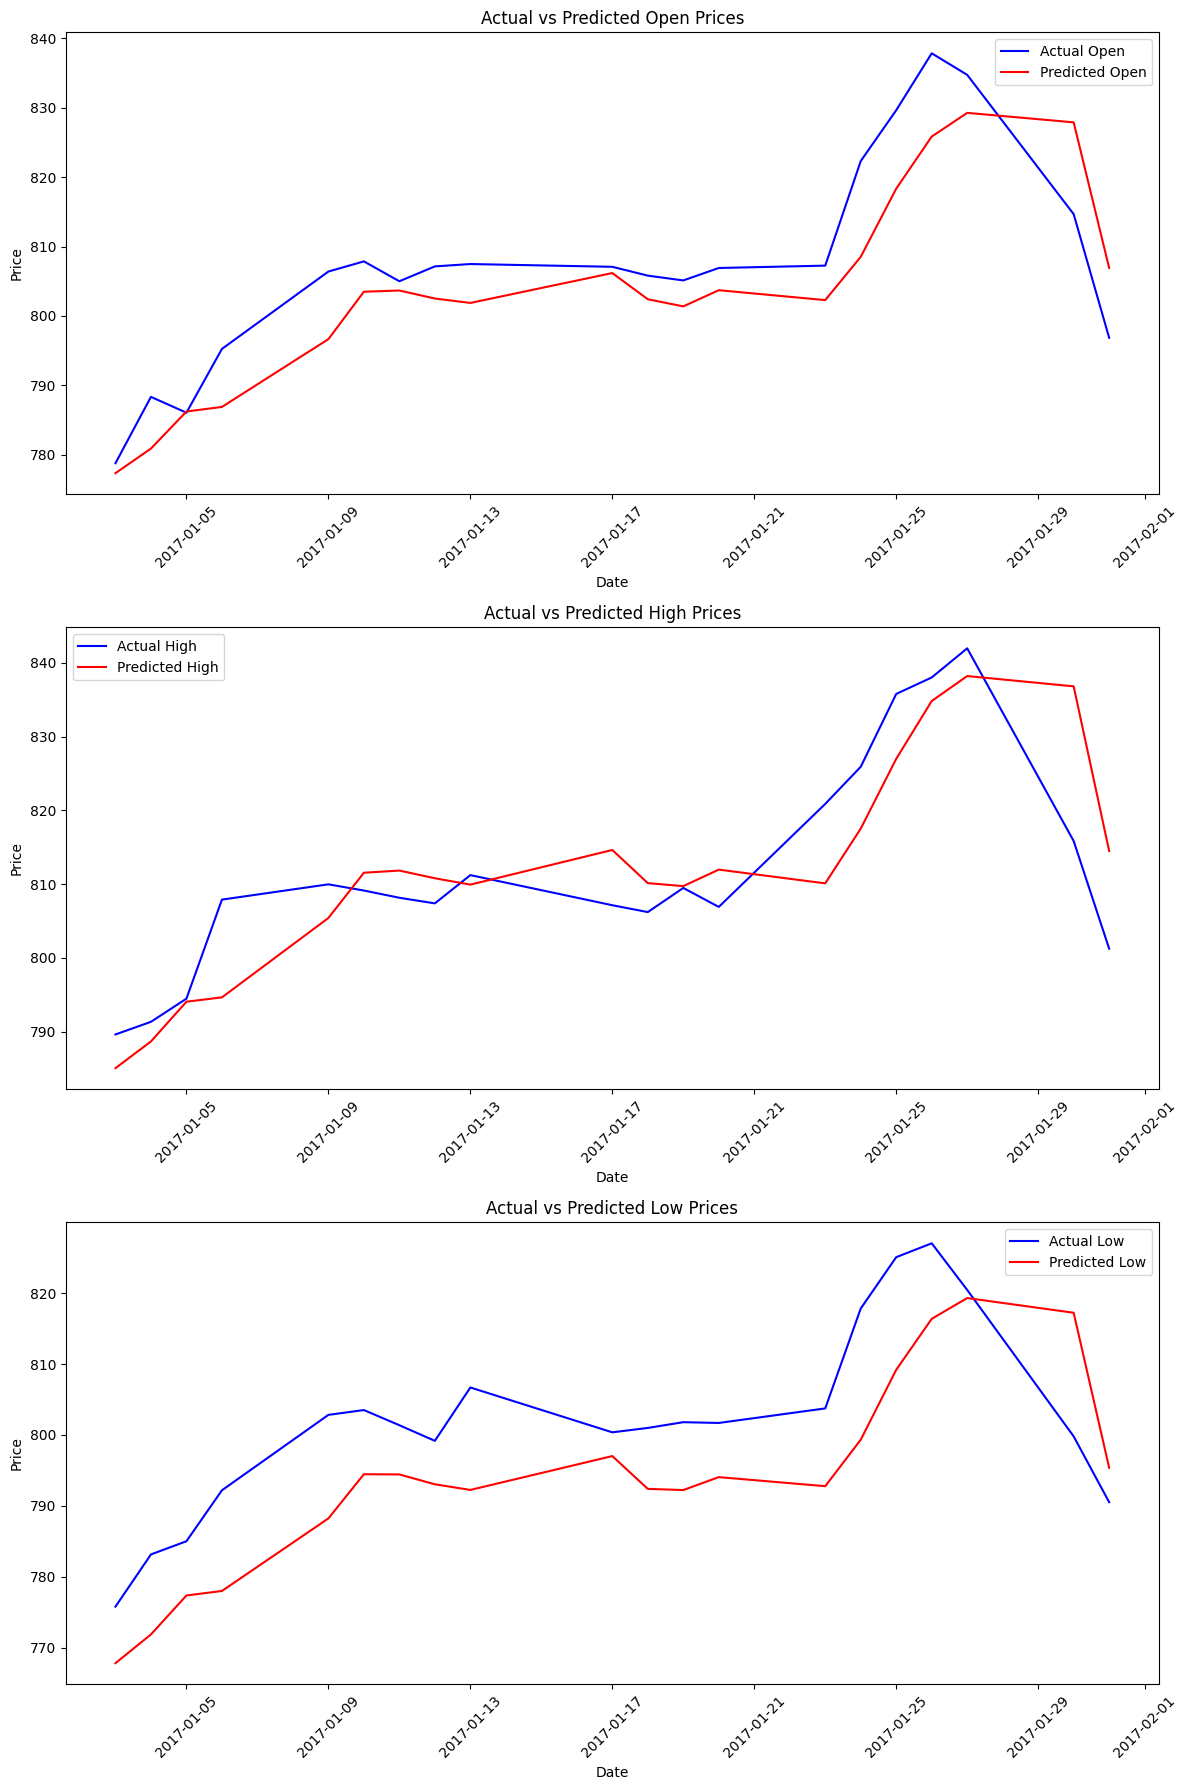

In [19]:
# Load the test dataset
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Extract features for testing
X_test = df_test[['Open', 'High', 'Low']].values  # Assuming all targets are included

# Scale the test features
X_test_scaled = scaler.transform(X_test)

# Prepare data for the model
last_val_entries = scaled_targets_val[-time_step:]  # Last 'time_step' entries from the validation set
concat_test_data = np.concatenate((last_val_entries, X_test_scaled), axis=0)
X_test, y_test = create_df_newset(concat_test_data, concat_test_data, time_step)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Make predictions
rnn_model.eval()
with torch.no_grad():
    test_predicted = rnn_model(X_test_tensor.to(device))

# Inverse transform the predicted values to original scale
test_predicted_inv = scaler.inverse_transform(test_predicted.cpu().numpy())
actual_test_inv = scaler.inverse_transform(y_test_tensor.numpy())

# Calculate RMSE for each target
rmse_open = np.sqrt(mean_squared_error(actual_test_inv[:, 0], test_predicted_inv[:, 0]))
rmse_high = np.sqrt(mean_squared_error(actual_test_inv[:, 1], test_predicted_inv[:, 1]))
rmse_low = np.sqrt(mean_squared_error(actual_test_inv[:, 2], test_predicted_inv[:, 2]))

# Print RMSE values
print(f"Test RMSE for Open: {rmse_open:.4f}")
print(f"Test RMSE for High: {rmse_high:.4f}")
print(f"Test RMSE for Low: {rmse_low:.4f}")

# Use the dates from the test dataset corresponding to the predictions
test_dates = df_test['Date'].values[-len(test_predicted_inv):]

# Create a new figure with subplots
plt.figure(figsize=(12, 18))

# Overlay for 'Open'
plt.subplot(3, 1, 1)
plt.plot(test_dates, actual_test_inv[:, 0], label='Actual Open', color='blue')
plt.plot(test_dates, test_predicted_inv[:, 0], label='Predicted Open', color='red')
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# Overlay for 'High'
plt.subplot(3, 1, 2)
plt.plot(test_dates, actual_test_inv[:, 1], label='Actual High', color='blue')
plt.plot(test_dates, test_predicted_inv[:, 1], label='Predicted High', color='red')
plt.title('Actual vs Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# Overlay for 'Low'
plt.subplot(3, 1, 3)
plt.plot(test_dates, actual_test_inv[:, 2], label='Actual Low', color='blue')
plt.plot(test_dates, test_predicted_inv[:, 2], label='Predicted Low', color='red')
plt.title('Actual vs Predicted Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# LSTM

In [20]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step
        return out

In [21]:
# Extract the date column
dates = df_new['Date'].values

# Select columns of interest for prediction
features = df_new[['Close']].values  # Selected columns
targets = df_new[['Close']].values  # Target columns

# Set the time step
time_step = 10

# Create sequences
def create_df_newset(features, targets, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step)])
        y.append(targets[i + time_step])
    return np.array(X), np.array(y)

# Split the df_newset into training and validation sets (80:20 ratio)
train_size = int(len(features) * 0.8)
features_train, features_val = features[:train_size], features[train_size:]
targets_train, targets_val = targets[:train_size], targets[train_size:]

# Scale the features and targets
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on the training df_new only
scaled_features_train = scaler.fit_transform(features_train)
scaled_targets_train = scaler.fit_transform(targets_train)

# Transform validation df_new using the fitted scalers
scaled_features_val = scaler.transform(features_val)
scaled_targets_val = scaler.transform(targets_val)

# Create sequences for training and validation sets
X_train, y_train = create_df_newset(scaled_features_train, scaled_targets_train, time_step)
X_val, y_val = create_df_newset(scaled_features_val, scaled_targets_val, time_step)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Epoch [1/1000], Loss: 0.2421, Val Loss: 0.6796
Epoch [2/1000], Loss: 0.1469, Val Loss: 0.4110
Epoch [3/1000], Loss: 0.0724, Val Loss: 0.1058
Epoch [4/1000], Loss: 0.0540, Val Loss: 0.0489
Epoch [5/1000], Loss: 0.0656, Val Loss: 0.1222
Epoch [6/1000], Loss: 0.0389, Val Loss: 0.2058
Epoch [7/1000], Loss: 0.0384, Val Loss: 0.2446
Epoch [8/1000], Loss: 0.0433, Val Loss: 0.2311
Epoch [9/1000], Loss: 0.0413, Val Loss: 0.1739
Epoch [10/1000], Loss: 0.0321, Val Loss: 0.0888
Epoch [11/1000], Loss: 0.0213, Val Loss: 0.0148
Epoch [12/1000], Loss: 0.0206, Val Loss: 0.0013
Epoch [13/1000], Loss: 0.0272, Val Loss: 0.0030
Epoch [14/1000], Loss: 0.0147, Val Loss: 0.0268
Epoch [15/1000], Loss: 0.0099, Val Loss: 0.0512
Epoch [16/1000], Loss: 0.0135, Val Loss: 0.0436
Epoch [17/1000], Loss: 0.0135, Val Loss: 0.0091
Epoch [18/1000], Loss: 0.0062, Val Loss: 0.0203
Epoch [19/1000], Loss: 0.0031, Val Loss: 0.0941
Epoch [20/1000], Loss: 0.0115, Val Loss: 0.0307
Epoch [21/1000], Loss: 0.0024, Val Loss: 0.0017
E

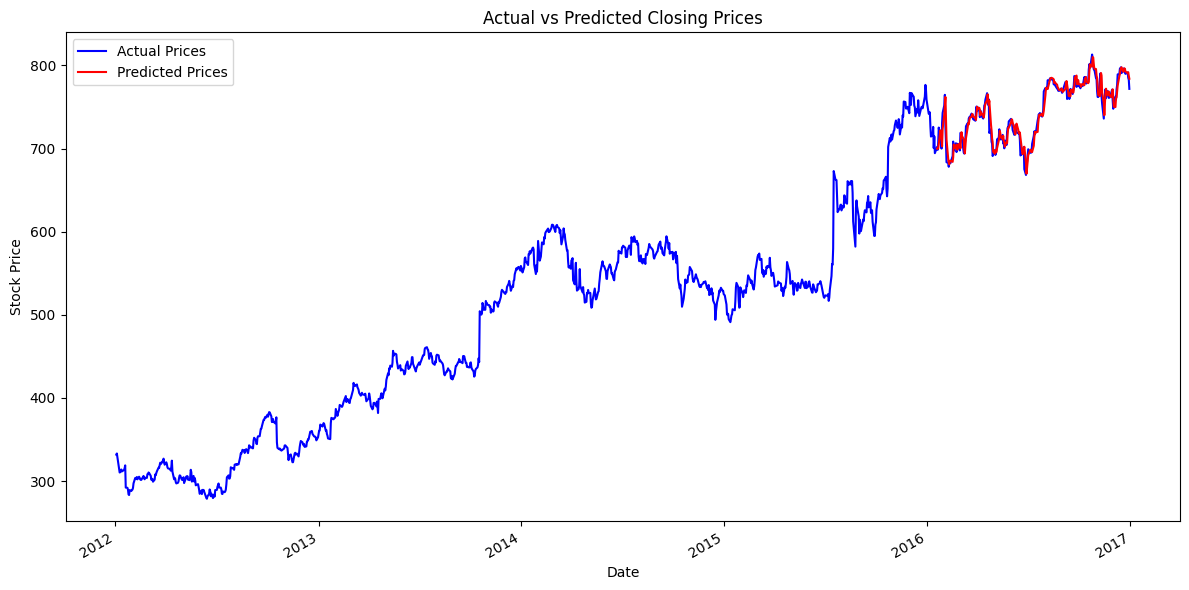

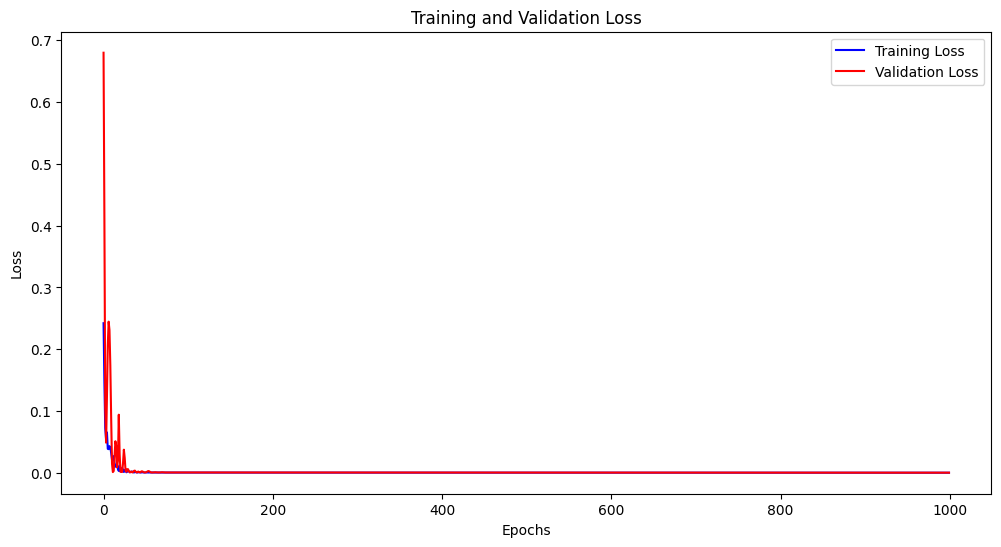

In [24]:
# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 50
num_layers = 1
output_size = y_train.shape[1]  # Number of targets (Open, High, Low)
num_epochs = 1000
batch_size = 5
learning_rate = 0.01

# Initialize the model
LSTM_model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)  # Move model to GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    LSTM_model.train()
    optimizer.zero_grad()
    outputs = LSTM_model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

    # Validation
    LSTM_model.eval()
    val_outputs = LSTM_model(X_val_tensor.to(device))
    val_loss = criterion(val_outputs, y_val_tensor.to(device))

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Make predictions
LSTM_model.eval()
with torch.no_grad():
    predicted_prices = LSTM_model(X_val_tensor.to(device))
    
# Inverse transform the predicted values to original scale
predicted_prices_inv = scaler.inverse_transform(predicted_prices.cpu().numpy())
actual_prices_inv = scaler.inverse_transform(y_val_tensor.numpy())
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices_inv, predicted_prices_inv))
print(f"-----\nRoot Mean Squared Error (RMSE): {rmse:.4f}\n-----")

df_new['Date'] = pd.to_datetime(df_new['Date'])

# Full actual prices and dates
full_actual_prices = df_new[['Close']].values
full_dates = df_new['Date'].values

# Create a new figure for the actual vs predicted prices
plt.figure(figsize=(12, 6))

# Plot the entire actual prices
plt.plot(full_dates, full_actual_prices, label='Actual Prices', color='blue')

# Calculate the starting index for the validation set
val_start_index = train_size + time_step  # Adjust for the time step
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv, 
         label='Predicted Prices', 
         color='red')

# Formatting the plot
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Improve x-axis date formatting
plt.gcf().autofmt_xdate()  # Auto format date labels
plt.legend()
plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test Uni Variate LSTM

Test RMSE for Close: 8.5529


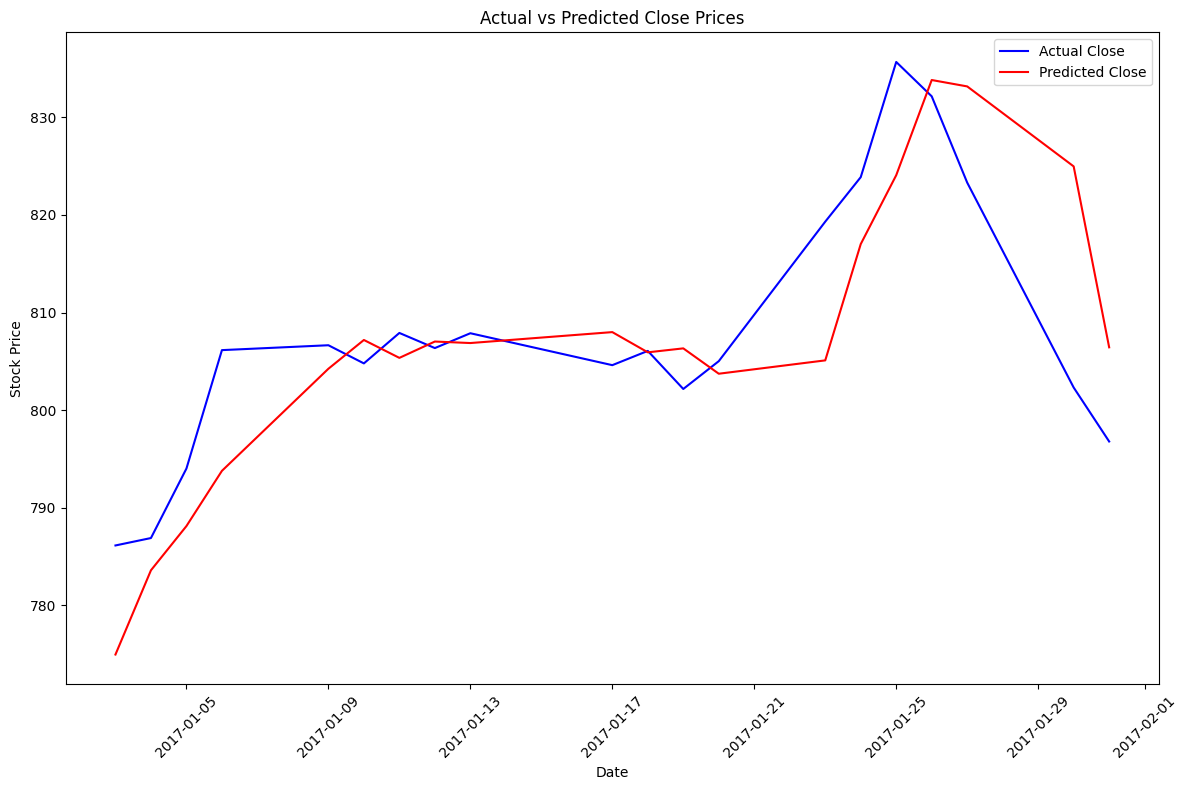

In [25]:
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
X_test = df_test[['Close']].values
# Scale the test features
X_test_scaled = scaler.transform(X_test)
last_val_entries = scaled_targets_val[-time_step:] # Last 'time_step' entries from the validation set
concat_test_data = np.concatenate((last_val_entries, X_test_scaled), axis=0)
X_test, y_test = create_df_newset(concat_test_data, concat_test_data, time_step)
# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Make predictions
LSTM_model.eval()
with torch.no_grad():
    test_predicted = LSTM_model(X_test_tensor.to(device))

# Inverse transform the predicted values to original scale
test_predicted_inv = scaler.inverse_transform(test_predicted.cpu().numpy())
actual_test_inv = scaler.inverse_transform(y_test_tensor.numpy())

# Calculate RMSE for each target
rmse = np.sqrt(mean_squared_error(actual_test_inv, test_predicted_inv))
print(f"Test RMSE for Close: {rmse:.4f}")

# Use the dates from the test dataset corresponding to the predictions
test_dates = df_test['Date'].values[-len(test_predicted_inv):]

# Plot actual vs predicted prices for 'Open', 'High', and 'Low'
plt.figure(figsize=(12, 8))

# Close
plt.plot(test_dates, actual_test_inv[:, 0], label='Actual Close', color='blue')
plt.plot(test_dates, test_predicted_inv[:, 0], label='Predicted Close', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Multivariate (Multi Output) LSTM

Epoch [1/1000], Loss: 0.2006, Val Loss: 0.2935
Epoch [2/1000], Loss: 0.0540, Val Loss: 0.0178
Epoch [3/1000], Loss: 0.1242, Val Loss: 0.1576
Epoch [4/1000], Loss: 0.0362, Val Loss: 0.2817
Epoch [5/1000], Loss: 0.0511, Val Loss: 0.3051
Epoch [6/1000], Loss: 0.0552, Val Loss: 0.2627
Epoch [7/1000], Loss: 0.0458, Val Loss: 0.1854
Epoch [8/1000], Loss: 0.0322, Val Loss: 0.1072
Epoch [9/1000], Loss: 0.0254, Val Loss: 0.0539
Epoch [10/1000], Loss: 0.0274, Val Loss: 0.0324
Epoch [11/1000], Loss: 0.0254, Val Loss: 0.0342
Epoch [12/1000], Loss: 0.0175, Val Loss: 0.0491
Epoch [13/1000], Loss: 0.0130, Val Loss: 0.0634
Epoch [14/1000], Loss: 0.0123, Val Loss: 0.0660
Epoch [15/1000], Loss: 0.0117, Val Loss: 0.0539
Epoch [16/1000], Loss: 0.0090, Val Loss: 0.0333
Epoch [17/1000], Loss: 0.0051, Val Loss: 0.0157
Epoch [18/1000], Loss: 0.0030, Val Loss: 0.0087
Epoch [19/1000], Loss: 0.0038, Val Loss: 0.0062
Epoch [20/1000], Loss: 0.0039, Val Loss: 0.0032
Epoch [21/1000], Loss: 0.0030, Val Loss: 0.0037
E

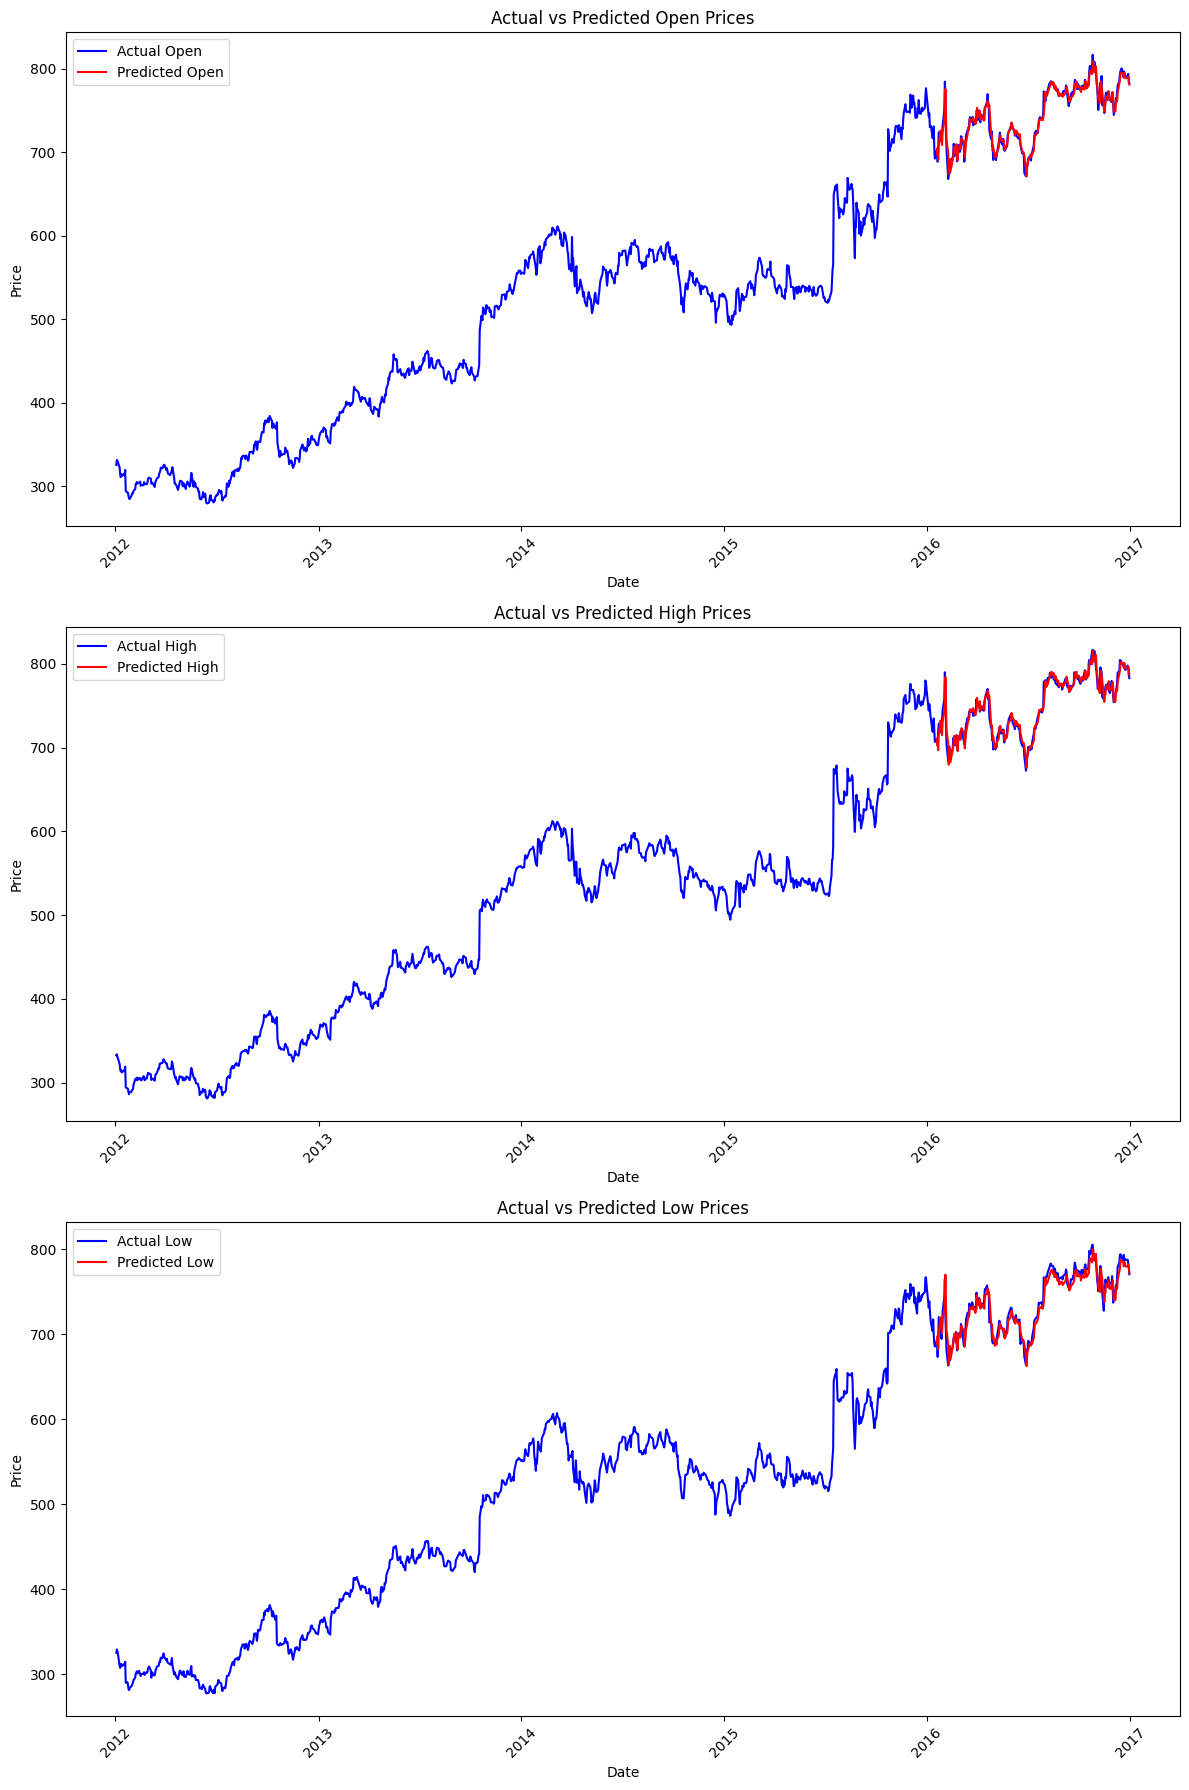

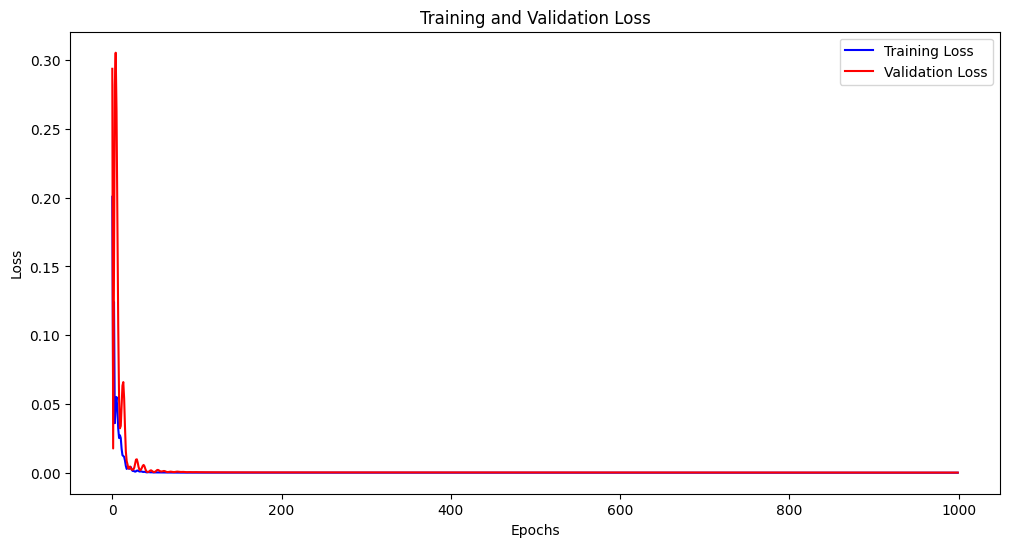

In [26]:
# Extract the date column
dates = pd.to_datetime(df_new['Date']).values

# Select columns of interest for prediction
features = df_new[['Open', 'High', 'Low']].values  # Selected columns
targets = df_new[['Open', 'High', 'Low']].values # Target columns

# Set the time step
time_step = 10

# Create sequences
def create_df_newset(features, targets, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step)])
        y.append(targets[i + time_step])
    return np.array(X), np.array(y)

# Split the df_newset into training and validation sets (80:20 ratio)
train_size = int(len(features) * 0.8)
features_train, features_val = features[:train_size], features[train_size:]
targets_train, targets_val = targets[:train_size], targets[train_size:]

# Scale the features and targets
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scalers on the training df_new only
scaled_features_train = scaler.fit_transform(features_train)
scaled_targets_train = scaler.fit_transform(targets_train)

# Transform validation df_new using the fitted scalers
scaled_features_val = scaler.transform(features_val)
scaled_targets_val = scaler.transform(targets_val)

# Create sequences for training and validation sets
X_train, y_train = create_df_newset(scaled_features_train, scaled_targets_train, time_step)
X_val, y_val = create_df_newset(scaled_features_val, scaled_targets_val, time_step)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 50
num_layers = 1
output_size = y_train.shape[1]  # Number of targets (Open, High, Low)
num_epochs = 1000
batch_size = 5
learning_rate = 0.01

# Initialize the model
LSTM_model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)  # Move model to GPU

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    LSTM_model.train()
    optimizer.zero_grad()
    outputs = LSTM_model(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

    # Validation
    LSTM_model.eval()
    val_outputs = LSTM_model(X_val_tensor.to(device))
    val_loss = criterion(val_outputs, y_val_tensor.to(device))

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Make predictions
LSTM_model.eval()
with torch.no_grad():
    predicted_prices = LSTM_model(X_val_tensor.to(device))
    
# Inverse transform the predicted values to original scale
predicted_prices_inv = scaler.inverse_transform(predicted_prices.cpu().numpy())
actual_prices_inv = scaler.inverse_transform(y_val_tensor.numpy())

# Calculate RMSE for each target
rmse_open = np.sqrt(mean_squared_error(targets[val_start_index:val_start_index + len(predicted_prices_inv), 0], 
                                         predicted_prices_inv[:, 0]))
rmse_high = np.sqrt(mean_squared_error(targets[val_start_index:val_start_index + len(predicted_prices_inv), 1], 
                                         predicted_prices_inv[:, 1]))
rmse_low = np.sqrt(mean_squared_error(targets[val_start_index:val_start_index + len(predicted_prices_inv), 2], 
                                         predicted_prices_inv[:, 2]))

# Print RMSE values
print(f"RMSE for Open: {rmse_open:.4f}")
print(f"RMSE for High: {rmse_high:.4f}")
print(f"RMSE for Low: {rmse_low:.4f}")

# Create a new figure with subplots
plt.figure(figsize=(12, 18))

# Overlay for 'Open'
plt.subplot(3, 1, 1)
plt.plot(full_dates, targets[:, 0], label='Actual Open', color='blue')
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv[:, 0], label='Predicted Open', color='red')
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.legend()

# Overlay for 'High'
plt.subplot(3, 1, 2)
plt.plot(full_dates, targets[:, 1], label='Actual High', color='blue')
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv[:, 1], label='Predicted High', color='red')
plt.title('Actual vs Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# Overlay for 'Low'
plt.subplot(3, 1, 3)
plt.plot(full_dates, targets[:, 2], label='Actual Low', color='blue')
plt.plot(full_dates[val_start_index:val_start_index + len(predicted_prices_inv)], 
         predicted_prices_inv[:, 2], label='Predicted Low', color='red')
plt.title('Actual vs Predicted Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()  # Adjust layout to make room for x-axis labels
plt.show()

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test LSTM multivariate (multi output)

Test RMSE for Open: 7.4080
Test RMSE for High: 7.9286
Test RMSE for Low: 10.9142


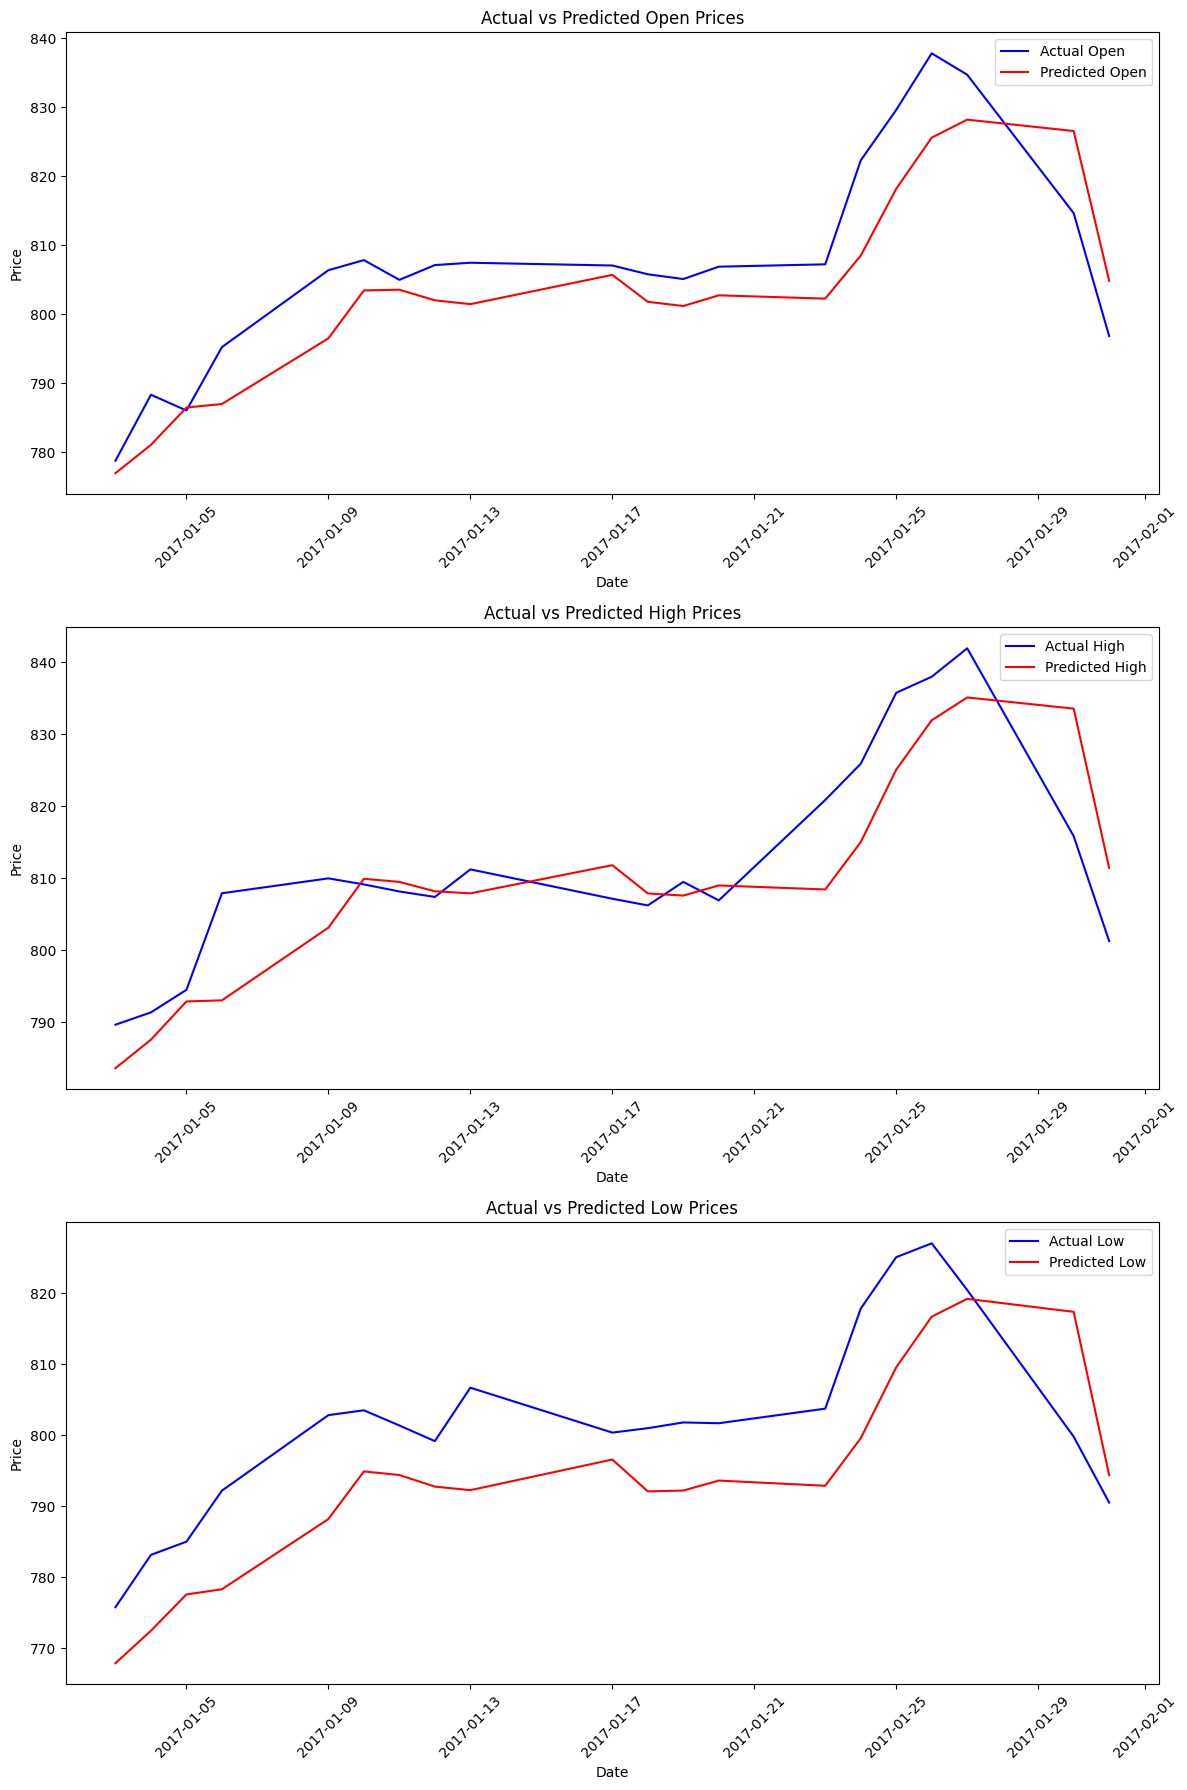

In [27]:
# Load the test dataset
df_test = pd.read_csv('Google_Stock_Price_Test.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Extract features for testing
X_test = df_test[['Open', 'High', 'Low']].values  # Assuming all targets are included

# Scale the test features
X_test_scaled = scaler.transform(X_test)

# Prepare data for the model
last_val_entries = scaled_targets_val[-time_step:]  # Last 'time_step' entries from the validation set
concat_test_data = np.concatenate((last_val_entries, X_test_scaled), axis=0)
X_test, y_test = create_df_newset(concat_test_data, concat_test_data, time_step)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Make predictions
LSTM_model.eval()
with torch.no_grad():
    test_predicted = LSTM_model(X_test_tensor.to(device))

# Inverse transform the predicted values to original scale
test_predicted_inv = scaler.inverse_transform(test_predicted.cpu().numpy())
actual_test_inv = scaler.inverse_transform(y_test_tensor.numpy())

# Calculate RMSE for each target
rmse_open = np.sqrt(mean_squared_error(actual_test_inv[:, 0], test_predicted_inv[:, 0]))
rmse_high = np.sqrt(mean_squared_error(actual_test_inv[:, 1], test_predicted_inv[:, 1]))
rmse_low = np.sqrt(mean_squared_error(actual_test_inv[:, 2], test_predicted_inv[:, 2]))

# Print RMSE values
print(f"Test RMSE for Open: {rmse_open:.4f}")
print(f"Test RMSE for High: {rmse_high:.4f}")
print(f"Test RMSE for Low: {rmse_low:.4f}")

# Use the dates from the test dataset corresponding to the predictions
test_dates = df_test['Date'].values[-len(test_predicted_inv):]

# Create a new figure with subplots
plt.figure(figsize=(12, 18))

# Overlay for 'Open'
plt.subplot(3, 1, 1)
plt.plot(test_dates, actual_test_inv[:, 0], label='Actual Open', color='blue')
plt.plot(test_dates, test_predicted_inv[:, 0], label='Predicted Open', color='red')
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# Overlay for 'High'
plt.subplot(3, 1, 2)
plt.plot(test_dates, actual_test_inv[:, 1], label='Actual High', color='blue')
plt.plot(test_dates, test_predicted_inv[:, 1], label='Predicted High', color='red')
plt.title('Actual vs Predicted High Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

# Overlay for 'Low'
plt.subplot(3, 1, 3)
plt.plot(test_dates, actual_test_inv[:, 2], label='Actual Low', color='blue')
plt.plot(test_dates, test_predicted_inv[:, 2], label='Predicted Low', color='red')
plt.title('Actual vs Predicted Low Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()